Project Steps

Steps we’ve covered so far:

1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform

After doing these steps, you’ll be given two additional steps for the project:

5. Detect lane lines
6. Determine the lane curvature


# detecting lane lines 

## 1. peaks in histogram

You now have a thresholded warped image and you're ready to map out the lane lines! There are many ways you could go about this, but here's one example of how you might do it:

** Line Finding Method: Peaks in a Histogram**

After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

Plotting a histogram of where the binary activations occur across the image is one potential solution for this. In the quiz below, let's take a couple quick steps to create our histogram!

In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('warped-example.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    half = int(img.shape[0]//2)
    bottom_half = img[half:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = bottom_half.sum(axis = 0)/''
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)

TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

As shown in the previous animation, we can use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.

## Split the histogram for the two lines
The first step we'll take is to split the histogram into two sides, one for each lane line.

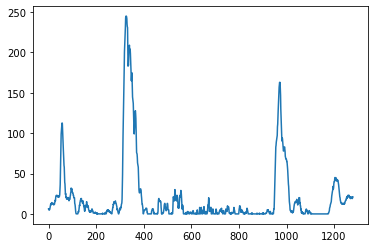

In [3]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
binary_warped = mpimg.imread('warped-example.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    half = int(img.shape[0]//2)
    bottom_half = img[half:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = bottom_half.sum(axis = 0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)

# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint]) # the index of the base of the left lane 
rightx_base = np.argmax(histogram[midpoint:]) + midpoint # right lane base point index

In [4]:
histogram.shape

(1280,)

In [5]:
a = [1,2,5,4,3,2]
np.argmax(a)

2

In [21]:
a[2]

5

In [24]:
(leftx_base,rightx_base)

(327, 971)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


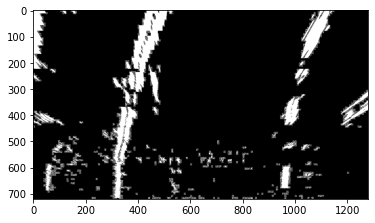

In [34]:
plt.imshow(out_img,cmap='gray')

## Set up windows and window hyperparameters
Our next step is to set a few hyperparameters related to our sliding windows, and set them up to iterate across the binary activations in the image. We have some base hyperparameters below, but don't forget to try out different values in your own implementation to see what works best!

In [26]:
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = binary_warped.nonzero() # return the indicies of the elements that are non zero
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [27]:
binary_warped.nonzero()

(array([  0,   0,   0, ..., 719, 719, 719], dtype=int64),
 array([   0,    1,    2, ..., 1051, 1067, 1069], dtype=int64))

## Iterate through nwindows to track curvature

In [60]:
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),
    (win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),
    (win_xright_high,win_y_high),(0,255,0), 2)
    
    # Identify the nonzero pixels in x and y within the window #
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    # good left indicies are the non zero indicies inside the left window
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

In [58]:
good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()

1

In [67]:
left_lane_inds = np.concatenate(left_lane_inds)


ValueError: zero-dimensional arrays cannot be concatenated

In [73]:
left_lane_inds

array([82135, 82136, 82137, ..., 14574, 14575, 14576], dtype=int64)

[82135 82136 82137 ... 14619 14620 14621]
[240 243 247 ... 488 491 494]
left fit [ 2.23090058e-04 -3.90812851e-01  4.78139852e+02]


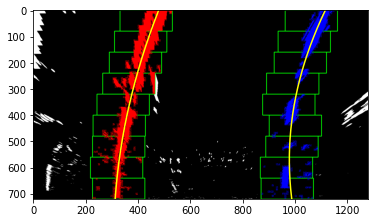

In [7]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
binary_warped = mpimg.imread('warped-example.jpg')

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    print(left_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    print(leftx)
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #print(binary_warped.shape)
    #print(ploty)
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    #out_img = cv2.l

    return out_img, left_fit,right_fit


out_img, left_fit, right_fit = fit_polynomial(binary_warped)

plt.imshow(out_img);
print('left fit {}'.format(left_fit))

In [79]:
len(left_lane_inds)

28701

In [80]:
nonzerox[left_lane_inds]

array([240, 243, 247, ..., 424, 425, 426], dtype=int64)

In [81]:
nonzero

(array([  0,   0,   0, ..., 719, 719, 719], dtype=int64),
 array([   0,    1,    2, ..., 1051, 1067, 1069], dtype=int64))

In [82]:
nonzerox

array([   0,    1,    2, ..., 1051, 1067, 1069], dtype=int64)

In [102]:
import sys
good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
np.set_printoptions(threshold=sys.maxsize)
print(good_left_inds)

[ 1806  2018  2437  2438  2829  3171  3172  4560  4713  4868  5025  5026
  5496  5497  5654  5811  5812  5813  5814  5981  5982  5983  5984  5985
  5986  5987  6152  6153  6154  6325  6326  6327  6328  6492  6493  6494
  6495  6496  6497  6498  6668  6669  6670  6671  6672  6842  6843  6844
  6845  6846  6847  6848  6849  6850  7019  7020  7021  7022  7023  7024
  7025  7026  7196  7197  7198  7199  7200  7201  7202  7203  7368  7369
  7370  7371  7372  7373  7374  7541  7542  7543  7544  7545  7546  7547
  7548  7549  7713  7714  7715  7716  7717  7718  7719  7720  7888  7889
  7890  7891  7892  7893  7894  8058  8059  8060  8061  8062  8063  8064
  8235  8236  8237  8238  8239  8240  8241  8242  8412  8413  8414  8415
  8416  8417  8418  8419  8592  8593  8594  8595  8596  8597  8770  8771
  8772  8773  8774  8775  8951  8952  8953  8954  8955  8956  8957  9135
  9136  9137  9138  9139  9140  9314  9315  9316  9317  9318  9319  9320
  9497  9498  9499  9500  9501  9502  9680  9681  9

In [94]:
np.array([False,True,True]).nonzero()

(array([1, 2], dtype=int64),)

In [ ]:
np.linspace()

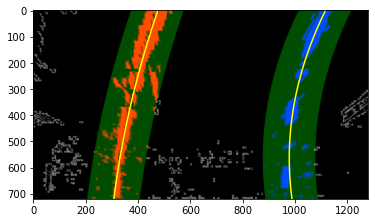

In [13]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread('warped_example.jpg')

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

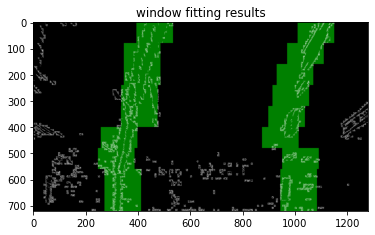

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = mpimg.imread('warped_example.jpg')
# window settings
window_width = 140
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

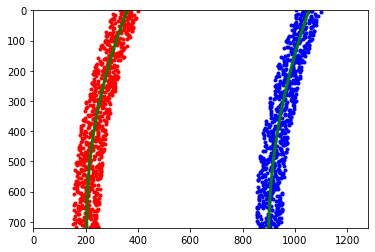

In [14]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [15]:
import numpy as np

def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit
    
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

1625.0601831657204 1976.2967307714591


In [16]:
import numpy as np

def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr
    
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

533.752588921091 m 648.1574851434378 m
